# Notes Analytics

Este notebook proporciona análisis básicos de los datos de notas almacenados en DynamoDB.

## Requisitos

1. Instalar dependencias:
   ```bash
   pip install boto3 pandas matplotlib seaborn jupyter
   ```

2. Configurar credenciales de AWS:
   - Opción 1: Usar `aws configure` para configurar credenciales por defecto
   - Opción 2: Usar variables de entorno:
     ```bash
     export AWS_PROFILE=personal
     export AWS_REGION=us-east-1
     ```
   - Opción 3: Configurar credenciales directamente en el notebook (ver celda siguiente)

3. Obtener el nombre de la tabla DynamoDB:
   - La tabla se llama `Notes` (definida en el CDK stack)
   - Puedes verificar con: `aws dynamodb list-tables`


In [1]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
from collections import Counter

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configurar cliente de DynamoDB
# Opción 1: Usar perfil de AWS (recomendado)
# Asegúrate de tener configurado: export AWS_PROFILE=personal
try:
    session = boto3.Session(profile_name='personal', region_name='us-east-1')
    dynamodb = session.resource('dynamodb')
    print("✅ Usando perfil AWS: personal")
except:
    # Opción 2: Usar credenciales por defecto
    dynamodb = boto3.resource('dynamodb', region_name='us-east-1')
    print("✅ Usando credenciales por defecto")

# Nombre de la tabla
TABLE_NAME = 'Notes'
table = dynamodb.Table(TABLE_NAME)

print(f"✅ Conectado a la tabla: {TABLE_NAME}")
print(f"✅ Región: us-east-1")


✅ Usando perfil AWS: personal
✅ Conectado a la tabla: Notes
✅ Región: us-east-1


In [3]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
from collections import Counter

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configurar cliente de DynamoDB
# Opción 1: Usar perfil de AWS (recomendado)
# Asegúrate de tener configurado: export AWS_PROFILE=personal
try:
    session = boto3.Session(profile_name='personal', region_name='us-east-1')
    dynamodb = session.resource('dynamodb')
    print("✅ Usando perfil AWS: personal")
except:
    # Opción 2: Usar credenciales por defecto
    dynamodb = boto3.resource('dynamodb', region_name='us-east-1')
    print("✅ Usando credenciales por defecto")

# Nombre de la tabla
TABLE_NAME = 'Notes'
table = dynamodb.Table(TABLE_NAME)

print(f"✅ Conectado a la tabla: {TABLE_NAME}")
print(f"✅ Región: us-east-1")


✅ Usando perfil AWS: personal
✅ Conectado a la tabla: Notes
✅ Región: us-east-1


In [4]:
def scan_table(table, limit=None):
    """
    Escanea toda la tabla de DynamoDB y retorna todos los items.
    Maneja la paginación automáticamente.
    """
    items = []
    scan_kwargs = {}
    
    if limit:
        scan_kwargs['Limit'] = limit
    
    done = False
    start_key = None
    while not done:
        if start_key:
            scan_kwargs['ExclusiveStartKey'] = start_key
        response = table.scan(**scan_kwargs)
        items.extend(response.get('Items', []))
        start_key = response.get('LastEvaluatedKey', None)
        done = start_key is None
    
    return items

# Obtener todos los datos
print("📊 Escaneando tabla DynamoDB...")
all_items = scan_table(table)
print(f"✅ Total de notas encontradas: {len(all_items)}")

# Convertir a DataFrame de pandas
if all_items:
    df = pd.DataFrame(all_items)

📊 Escaneando tabla DynamoDB...
✅ Total de notas encontradas: 6


## 1. Distribución de Sentimientos (Gráfico Circular)


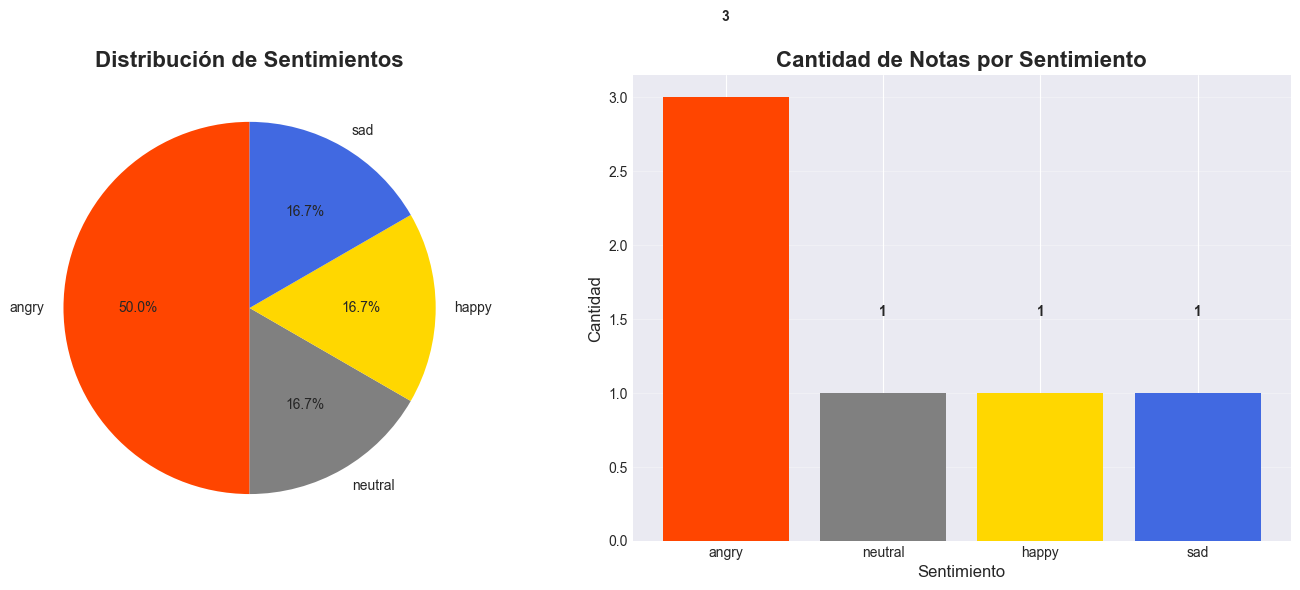


📊 Resumen de sentimientos:
sentiment
angry      3
neutral    1
happy      1
sad        1
Name: count, dtype: int64


In [5]:
if not df.empty:
    # Contar sentimientos
    sentiment_counts = df['sentiment'].value_counts()
    
    # Crear gráfico de pastel
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfico de pastel
    colors = {'happy': '#FFD700', 'sad': '#4169E1', 'neutral': '#808080', 'angry': '#FF4500'}
    sentiment_colors = [colors.get(s, '#CCCCCC') for s in sentiment_counts.index]
    
    ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=sentiment_colors, startangle=90)
    ax1.set_title('Distribución de Sentimientos', fontsize=16, fontweight='bold')
    
    # Gráfico de barras
    ax2.bar(sentiment_counts.index, sentiment_counts.values, color=sentiment_colors)
    ax2.set_title('Cantidad de Notas por Sentimiento', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Sentimiento', fontsize=12)
    ax2.set_ylabel('Cantidad', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for i, v in enumerate(sentiment_counts.values):
        ax2.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Resumen de sentimientos:")
    print(sentiment_counts)
else:
    print("⚠️ No hay datos para visualizar.")


## 2. Histograma de Notas por Día


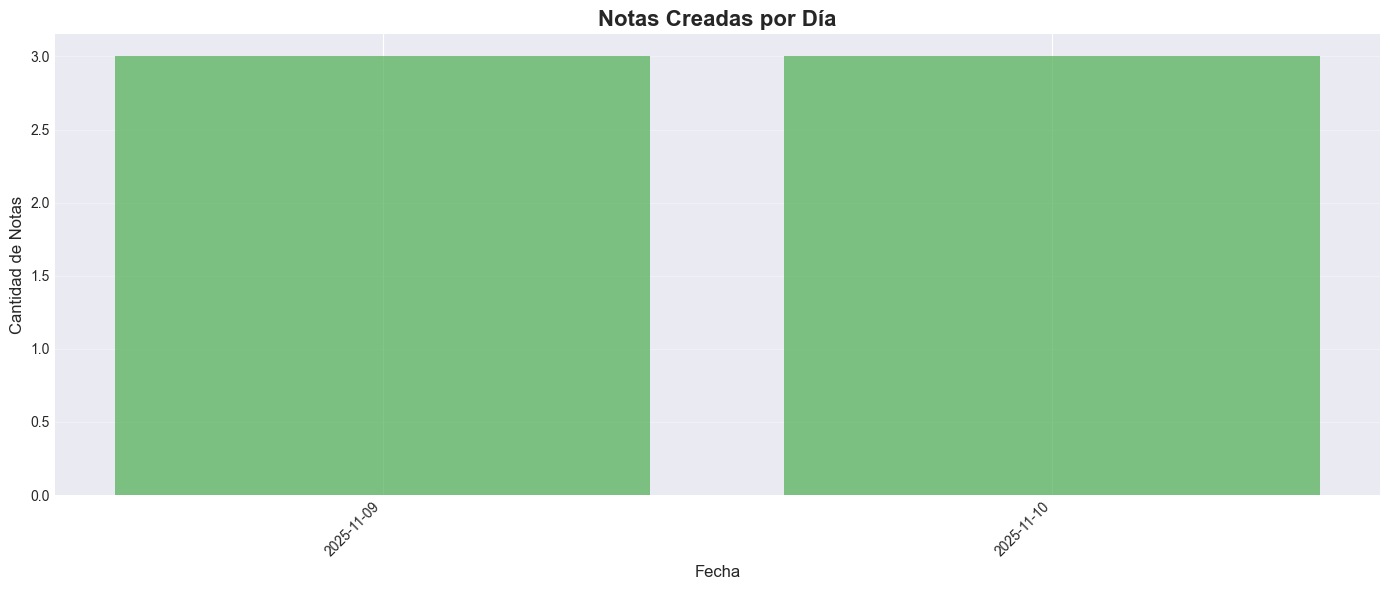


📈 Resumen:
Total de días con notas: 2
Promedio de notas por día: 3.00
Máximo de notas en un día: 3
Fecha con más notas: 2025-11-09


In [8]:
if not df.empty:
    # Agrupar por fecha (solo día, sin hora)
    df['date'] = df['dateCreated'].dt.date
    notes_per_day = df.groupby('date').size()
    
    # Crear histograma
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Si hay muchas fechas, agrupar por semana
    if len(notes_per_day) > 30:
        df['week'] = df['dateCreated'].dt.to_period('W')
        notes_per_week = df.groupby('week').size()
        notes_per_week.index = notes_per_week.index.astype(str)
        ax.bar(range(len(notes_per_week)), notes_per_week.values, color='#4CAF50', alpha=0.7)
        ax.set_xticks(range(len(notes_per_week)))
        ax.set_xticklabels(notes_per_week.index, rotation=45, ha='right')
        ax.set_xlabel('Semana', fontsize=12)
        ax.set_title('Notas Creadas por Semana', fontsize=16, fontweight='bold')
    else:
        ax.bar(range(len(notes_per_day)), notes_per_day.values, color='#4CAF50', alpha=0.7)
        ax.set_xticks(range(len(notes_per_day)))
        ax.set_xticklabels([str(d) for d in notes_per_day.index], rotation=45, ha='right')
        ax.set_xlabel('Fecha', fontsize=12)
        ax.set_title('Notas Creadas por Día', fontsize=16, fontweight='bold')
    
    ax.set_ylabel('Cantidad de Notas', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Resumen:")
    print(f"Total de días con notas: {len(notes_per_day)}")
    print(f"Promedio de notas por día: {notes_per_day.mean():.2f}")
    print(f"Máximo de notas en un día: {notes_per_day.max()}")
    print(f"Fecha con más notas: {notes_per_day.idxmax()}")
else:
    print("⚠️ No hay datos para visualizar.")


## 3. Análisis por Usuario (Nuevo - Cognito)


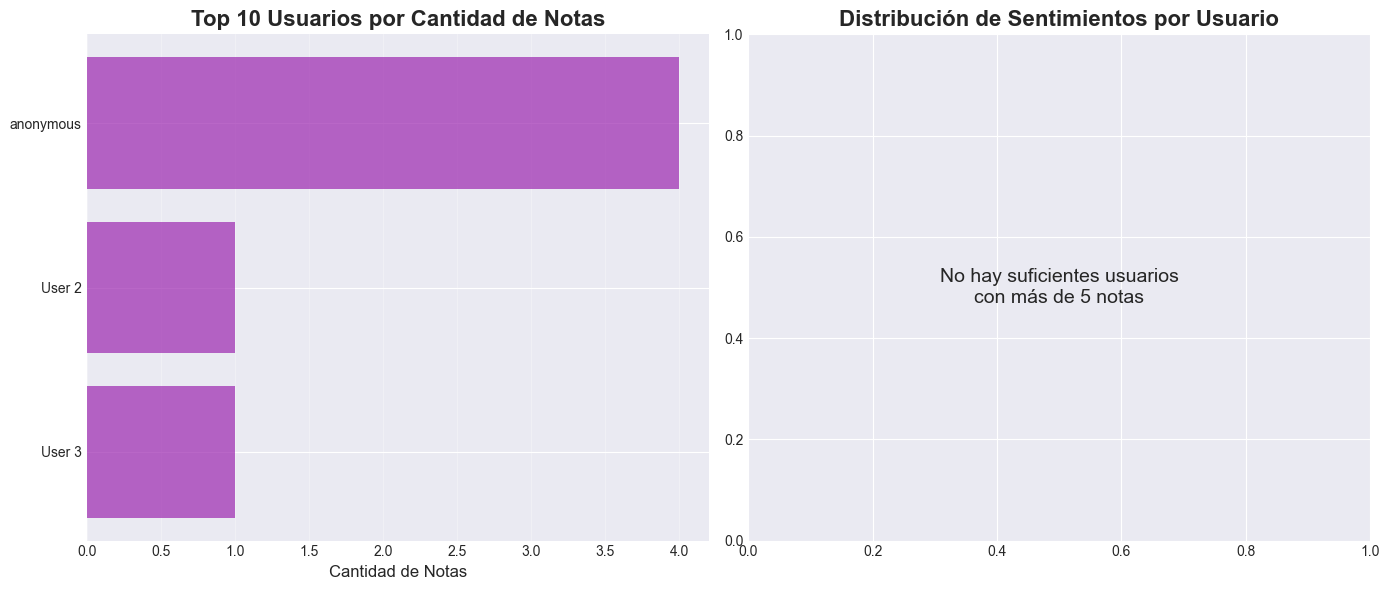


👥 Resumen de usuarios:
Total de usuarios únicos: 3
Usuario más activo: anonymous (4 notas)

Top 5 usuarios:
userId
anonymous                               4
8408f4f8-e0e1-70cc-d0aa-72d55e46f6cb    1
a498f418-d0c1-709f-5104-695df1a659ab    1
Name: count, dtype: int64


In [9]:
if not df.empty:
    # Contar notas por usuario
    user_counts = df['userId'].value_counts()
    
    # Crear visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Top 10 usuarios
    top_users = user_counts.head(10)
    
    # Gráfico de barras horizontal
    ax1.barh(range(len(top_users)), top_users.values, color='#9C27B0', alpha=0.7)
    ax1.set_yticks(range(len(top_users)))
    ax1.set_yticklabels([f"User {i+1}" if len(str(u)) > 20 else str(u)[:20] for i, u in enumerate(top_users.index)])
    ax1.set_xlabel('Cantidad de Notas', fontsize=12)
    ax1.set_title('Top 10 Usuarios por Cantidad de Notas', fontsize=16, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Invertir orden (mayor a menor)
    ax1.invert_yaxis()
    
    # Distribución de sentimientos por usuario (solo para usuarios con más de 5 notas)
    active_users = user_counts[user_counts > 5].index
    if len(active_users) > 0:
        user_sentiment = df[df['userId'].isin(active_users)].groupby(['userId', 'sentiment']).size().unstack(fill_value=0)
        
        # Tomar solo los primeros 5 usuarios más activos para el gráfico
        top_5_users = user_counts.head(5).index
        user_sentiment_top = user_sentiment.loc[top_5_users]
        
        colors = {'happy': '#FFD700', 'sad': '#4169E1', 'neutral': '#808080', 'angry': '#FF4500'}
        user_sentiment_top.plot(kind='bar', stacked=True, ax=ax2, 
                               color=[colors.get(s, '#CCCCCC') for s in user_sentiment_top.columns])
        ax2.set_title('Distribución de Sentimientos por Usuario (Top 5)', fontsize=16, fontweight='bold')
        ax2.set_xlabel('Usuario', fontsize=12)
        ax2.set_ylabel('Cantidad de Notas', fontsize=12)
        ax2.legend(title='Sentimiento', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.set_xticklabels([f"User {i+1}" if len(str(u)) > 15 else str(u)[:15] 
                            for i, u in enumerate(user_sentiment_top.index)], rotation=45, ha='right')
    else:
        ax2.text(0.5, 0.5, 'No hay suficientes usuarios\ncon más de 5 notas', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=14)
        ax2.set_title('Distribución de Sentimientos por Usuario', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n👥 Resumen de usuarios:")
    print(f"Total de usuarios únicos: {len(user_counts)}")
    print(f"Usuario más activo: {user_counts.index[0]} ({user_counts.iloc[0]} notas)")
    print(f"\nTop 5 usuarios:")
    print(user_counts.head(5))
else:
    print("⚠️ No hay datos para visualizar.")


## 4. Análisis de Tendencias Temporales


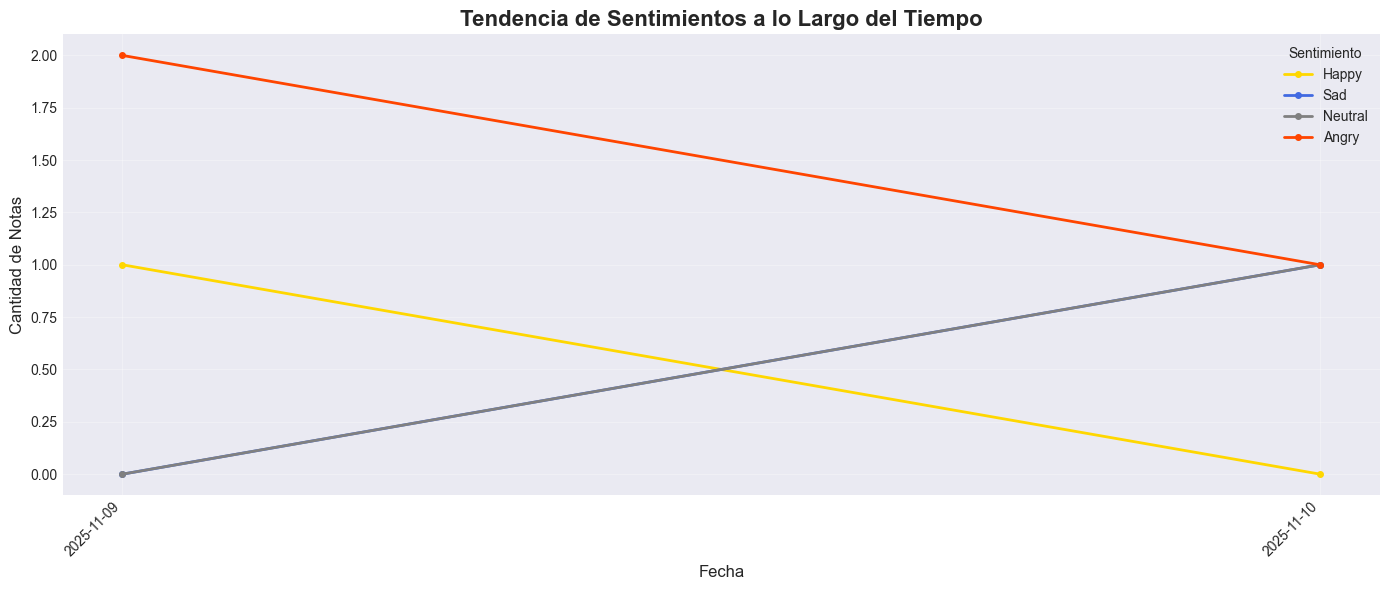


📅 Estadísticas temporales:
Primera nota: 2025-11-09 22:33:52.604000+00:00
Última nota: 2025-11-10 01:43:32.276000+00:00
Rango de días: 0 días


In [10]:
if not df.empty:
    # Agrupar por fecha y sentimiento
    df['date'] = df['dateCreated'].dt.date
    daily_sentiment = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)
    
    # Crear gráfico de líneas
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = {'happy': '#FFD700', 'sad': '#4169E1', 'neutral': '#808080', 'angry': '#FF4500'}
    
    for sentiment in ['happy', 'sad', 'neutral', 'angry']:
        if sentiment in daily_sentiment.columns:
            ax.plot(range(len(daily_sentiment)), daily_sentiment[sentiment], 
                   marker='o', label=sentiment.capitalize(), 
                   color=colors.get(sentiment, '#CCCCCC'), linewidth=2, markersize=4)
    
    ax.set_xticks(range(len(daily_sentiment)))
    ax.set_xticklabels([str(d) for d in daily_sentiment.index], rotation=45, ha='right')
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Cantidad de Notas', fontsize=12)
    ax.set_title('Tendencia de Sentimientos a lo Largo del Tiempo', fontsize=16, fontweight='bold')
    ax.legend(title='Sentimiento', loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas adicionales
    print("\n📅 Estadísticas temporales:")
    print(f"Primera nota: {df['dateCreated'].min()}")
    print(f"Última nota: {df['dateCreated'].max()}")
    print(f"Rango de días: {(df['dateCreated'].max() - df['dateCreated'].min()).days} días")
else:
    print("⚠️ No hay datos para visualizar.")
